In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import os

from IPython.display import display


## score functions

In [2]:
def score_GVP(dy, ceil = 2.):
    gvp = (1.0 + (dy/5.0)**2)**0.5 - 1.0
    res = np.clip(gvp, 0., ceil) # if gvp < ceil {gvp} else {ceil};
    return 100.*res


In [3]:
data = "CGM_p77_40D"
diff = "CGMDIFF"+data[3:]

df = pd.read_csv("data/%s.csv"%data, header=None, names=["ts","CGM"])
df["TIR"] = df["CGM"].apply(lambda x: 100.0 if ((x<180) & (x>70)) else 0.0)
df["H70"] = df["CGM"].apply(lambda x: 100.0 if (x<70) else 0.0)
df["H54"] = df["CGM"].apply(lambda x: 100.0 if (x<54) else 0.0)

df["DIFF"] = pd.read_csv("data/%s.csv"%diff, header=None, index_col=0).values
df["ABS50"] = df["DIFF"].clip(-50.,50.).apply(np.abs)
df["RDV"] = df["DIFF"].apply(lambda x: 10*score_GVP(x, 10)/100)

print(df.shape)
df.head()


(11520, 8)


,ts,CGM,TIR,H70,H54,DIFF,ABS50,RDV
0,2021-08-07 07:53:40,145.823333,100.0,0.0,0.0,3.658667,3.658667,2.391262
1,2021-08-07 07:58:40,152.420000,100.0,0.0,0.0,6.596667,6.596667,6.554880
2,2021-08-07 08:03:40,158.823333,100.0,0.0,0.0,6.403333,6.403333,6.248406
3,2021-08-07 08:08:40,165.823333,100.0,0.0,0.0,7.000000,7.000000,7.204651
4,2021-08-07 08:13:40,172.420000,100.0,0.0,0.0,6.596667,6.596667,6.554880


In [4]:
dfh = df.groupby(df.index//12).mean()
print(dfh.shape, len(df)/12)
dfh.head()


(960, 7) 960.0


,CGM,TIR,H70,H54,DIFF,ABS50,RDV
0,176.990267,50.000000,0.0,0.0,3.972684,4.754383,4.470832
1,182.215312,33.333333,0.0,0.0,-1.172549,1.172549,0.271294
2,168.144729,100.000000,0.0,0.0,-1.172549,1.172549,0.271294
3,146.342611,100.000000,0.0,0.0,-3.203698,3.962968,2.823029
4,95.301333,100.000000,0.0,0.0,-4.300000,4.300000,3.189390


In [5]:
window = 128
dfr = dfh.rolling(window).mean()
dfr = dfr.reset_index(drop=True).dropna()
print(dfr.shape)
dfr.head()


(833, 7)


,CGM,TIR,H70,H54,DIFF,ABS50,RDV
127,151.309790,78.776042,1.5625,0.520833,-0.018434,3.688908,3.464265
128,150.763772,79.166667,1.5625,0.520833,-0.054256,3.676298,3.447018
129,150.101304,79.687500,1.5625,0.520833,-0.048416,3.686972,3.460844
130,149.705035,79.687500,1.5625,0.520833,0.002585,3.722343,3.514271
131,149.864342,79.687500,1.5625,0.520833,0.032397,3.705656,3.498290


## hourly series

In [6]:
allfiles = glob("data/*/%s*hourly.csv"%data) + glob("data/*/%s*hourly.csv"%diff)

dth = {"CGM": {}}

for filepath in allfiles:
    _, keys, filename = filepath.split("/")
    name, _ = filename.split(".")
    tmp = name.split("_")
    tag = keys+"_"+"_".join(tmp[3:6])
    idx = "_".join(tmp[6:-1])
    if "DIFF" in name:
        idx = idx + "_DIFF"
    if idx not in dth.keys():
        dth[idx] = {}
    #print(tag, idx)
    dth[idx][tag] = pd.read_csv(filepath, header=None).values[:,0]
            
{key:len(dth[key]) for key in dth.keys()}


{'CGM': 1,
 'TIR_CGM': 1,
 'H70_CGM': 1,
 'H54_CGM': 1,
 'RDV_CGM_DIFF': 1,
 'ABS50_CGM_DIFF': 1}

In [61]:
#fig, axs = plt.subplots(3,2, figsize=(12, 8))
for i, idx in enumerate(dth.keys()):
    tmp = pd.DataFrame(dth[idx], index=None)
    #axs[i%3,i//3].plot(tmp)
    tst = dfh[idx.split("_")[:1]]
    #axs[i%3,i//3].plot(tst)
    err = tmp - tst.values
    #axs[i%3,i//3].plot(err)
    print("\n\n", idx, tst.shape, tmp.shape, err.shape)       
    stats = err.describe().T[["mean","std","25%","50%","75%"]]
    stats["rmse"] = (stats["mean"]**2 + stats["std"]**2)**0.5
    stats["avg"] = tst.mean()[0]
    stats["rel"] = stats["rmse"]/stats["avg"]
    display(stats)
#plt.show()




 CGM (960, 1) (960, 1) (960, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_400,-0.103239,4.865852,-3.208408,-0.166338,3.281145,4.866947,160.750282,0.030276




 TIR_CGM (960, 1) (960, 1) (960, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_400,-0.110405,4.155178,-0.893942,0.0,0.502962,4.156645,66.623264,0.06239




 H70_CGM (960, 1) (960, 1) (960, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_400,0.96767,2.038585,0.129595,0.888721,1.530987,2.256594,1.475694,1.529174




 H54_CGM (960, 1) (960, 1) (960, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_400,0.965584,1.086132,0.128714,0.765359,1.532345,1.453284,0.425347,3.416701




 RDV_CGM_DIFF (960, 1) (960, 1) (960, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_50,0.35241,1.153424,-0.39715,0.337996,1.135684,1.20606,2.972226,0.405777




 ABS50_CGM_DIFF (960, 1) (960, 1) (960, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_50,0.123957,0.642235,-0.302464,0.155209,0.56944,0.654088,3.320354,0.196993


## rolling series

In [63]:
allfiles = glob("data/*/%s*hourly_rolling_128.csv"%data) + glob("data/*/%s*hourly_rolling_128.csv"%diff)

dtr = {}

for filepath in allfiles:
    _, keys, filename = filepath.split("/")
    name, _ = filename.split(".")
    tmp = name.split("_")
    tag = keys+"_"+"_".join(tmp[3:6])
    idx = "_".join(tmp[6:-1])
    if "DIFF" in name:
        idx = idx + "_DIFF"
    if idx not in dth.keys():
        dtr[idx] = {}
    #print(tag, idx)
    dtr[idx][tag] = pd.read_csv(filepath, header=None).values[:,0]
            
{key:len(dtr[key]) for key in dtr.keys()}


{'CGM_hourly_rolling': 1,
 'TIR_CGM_hourly_rolling': 1,
 'H54_CGM_hourly_rolling': 1,
 'H70_CGM_hourly_rolling': 1}

NameError: name 'nom' is not defined



 CGM_hourly_rolling (833, 1) (833, 1) (833, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_400,0.007227,3.974512,-2.592521,0.134483,2.370247,3.974519,162.403218,0.024473




 TIR_CGM_hourly_rolling (833, 1) (833, 1) (833, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_400,-0.003162,1.082603,-0.77323,0.038486,0.738521,1.082608,65.712613,0.016475




 H54_CGM_hourly_rolling (833, 1) (833, 1) (833, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_400,1.199301,0.839621,0.559237,1.228432,1.755945,1.463997,0.403755,3.625951




 H70_CGM_hourly_rolling (833, 1) (833, 1) (833, 1)


,mean,std,25%,50%,75%,rmse,avg,rel
80_1024_1_6_4_2_3_400,1.035064,0.911086,0.462932,1.043225,1.68832,1.378925,1.471761,0.936922


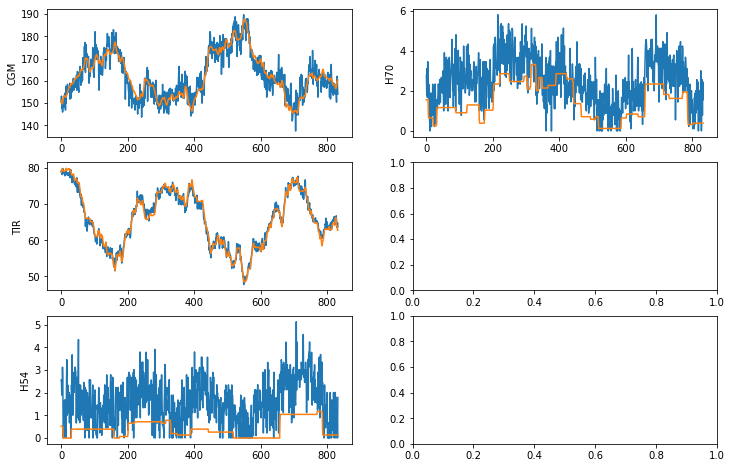

In [81]:
fig, axs = plt.subplots(3,2, figsize=(12, 8))
for i, idx in enumerate(dtr.keys()):
    nom = idx.split("_")[0]
    axs[i%3,i//3].set_ylabel(nom)
    tmp = pd.DataFrame(dtr[idx], index=None)
    axs[i%3,i//3].plot(tmp)
    tst = dfr[[nom]].reset_index(drop=True)
    axs[i%3,i//3].plot(tst)
    err = tmp - tst.values
    #axs[i%3,i//3].plot(err)
    print("\n\n", idx, tst.shape, tmp.shape, err.shape)  
    stats = err.describe().T[["mean","std","25%","50%","75%"]]
    stats["rmse"] = (stats["mean"]**2 + stats["std"]**2)**0.5
    stats["avg"] = tst.mean()[0]
    stats["rel"] = stats["rmse"]/stats["avg"]
    display(stats)
plt.show()
